In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
datadir = '../Datasets/'

In [2]:
## To produce LaTeX from a DataFrame
#df = df.round(decimals=3)
#print(df.to_latex(index=False))
#print(df.to_latex(index=True))

In [4]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

## US Airport Volume of Passengers

In [5]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
g = g.simplify()

## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs['color'] = cls[1]
g.es()['color'] = cls_edges


## Useful functions


In [7]:
## Degree correlation functions
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v, mode='out')))]
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v)))]
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graphs
## can also be computed as <k^2>/<k>
def deg_corr_random(G):
    deg = G.degree()
    L = []
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v)))]
        L.extend(w)
    return np.mean(L)
def deg_corr_random_directed(G, mode='all'):
    deg = G.degree(mode=mode)
    L = []
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v,mode='out')))]
        L.extend(w)
    return np.mean(L)

## Correlation exponent via libear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

def richClub(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     


## Directed Degree Correltion Functions (4 cases)

Dashed line for neutral graphs

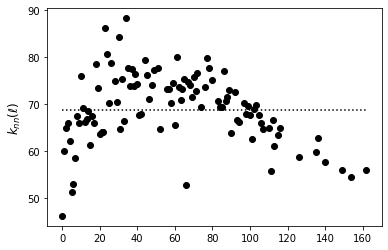

In [9]:
knn = deg_corr_directed(g,'in','in')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random_directed(g,'in')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_in_in.eps')

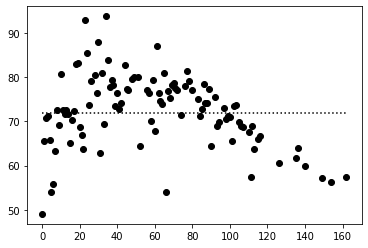

In [10]:
knn = deg_corr_directed(g,'in','out')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random_directed(g,'out')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':');
#plt.savefig('degree_corr_in_out.eps')

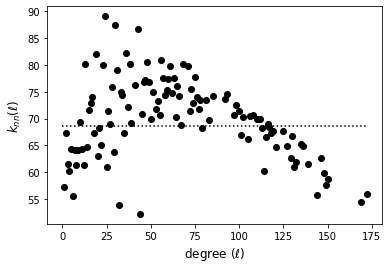

In [12]:
knn = deg_corr_directed(g,'out','in')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random_directed(g,'in')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_out_in.eps')

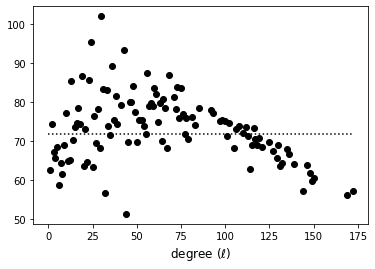

In [13]:
knn = deg_corr_directed(g,'out','out')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random_directed(g,'out')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12);
#plt.savefig('degree_corr_out_out.eps')

## Consider undirected graph from now on


In [14]:
## Undirected graph
g = g.as_undirected()
g.es()['color'] = cls_edges


## Degree correlation: also look via log scale

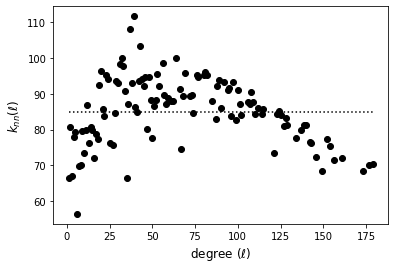

In [15]:
knn = deg_corr(g)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(g)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_linear.eps')

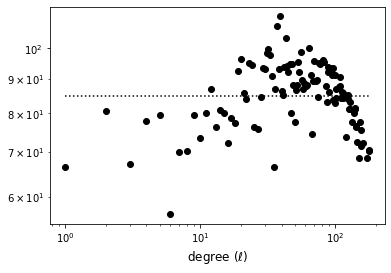

In [16]:
plt.loglog(x,y,'o',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12);
#plt.savefig('degree_corr_log.eps');

## State by state assortativity and correlation exponent

In [17]:
## for each state compute degree assortativity (r)
## also estimate correlation exponent (mu) via regression (taking the logs)
## Show assortativity and mu for states with 5+ vertices
L = []
for s in set(list(A['state'])):
    ## Build state subgraph
    hva = [v for v in g.vs() if v['state'] == s]
    G = g.subgraph(hva)
    ## drop isolated vertices (i.e. without in-state connections)
    G = G.subgraph([v for v in G.vs() if v.degree()>0])
    ## remove loops
    G = G.simplify(multiple=False)
    ## only consider graphs with > 5 vertices
    if G.vcount() >= 6:
        mu = corr_exp(G)        
        L.append([s,G.vcount(),G.ecount(),G.assortativity_degree(),mu])
P = pd.DataFrame(L,columns=['state','nodes','edges','assortativity','mu'])
P = P.sort_values(by='assortativity')

In [18]:
## top r (starting from -1)
df = P.head(5)
df

,state,nodes,edges,assortativity,mu
22,NE,6,4,-1.000000,-1.000000
2,UT,6,6,-0.833333,-0.801870
23,MN,6,6,-0.833333,-0.801870
8,AZ,7,9,-0.601423,-0.612467
9,MO,11,18,-0.546798,-0.344853


In [19]:
## bottom r (positive r)
df = P.tail(3)
df

,state,nodes,edges,assortativity,mu
15,SD,6,7,0.263158,0.268328
0,ND,6,6,0.400000,0.858867
13,AR,7,9,1.000000,1.000000


Person correlation: 0.9649505377639609


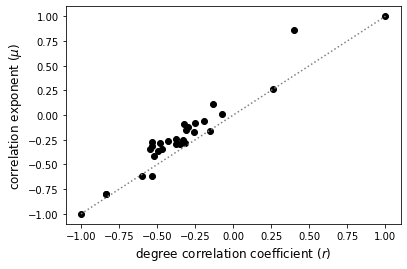

In [20]:
## some states are quite small, 
## but we still see good correlation between r and mu
plt.plot(P['assortativity'],P['mu'],'o',color='black')
plt.xlabel('degree correlation coefficient ($r$)',fontsize=12)
plt.ylabel(r'correlation exponent ($\mu$)',fontsize=12)
print('Person correlation:',np.corrcoef(P['assortativity'],P['mu'])[1,0])
ident = [-1.0, 1.0]
plt.plot(ident,ident,':',c='gray');
#plt.savefig('mu.eps')

## Looking at a few states with high/low assortativity

r = 0.24324324324324326


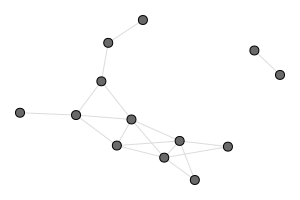

In [21]:
## positive case: Dakota (ND+SD)
hva = [v for v in g.vs() if v['state'] == 'SD' or v['state'] == 'ND']
G_D = g.subgraph(hva)
G_D = G_D.subgraph([v for v in G_D.vs() if v.degree()>0])
G_D = G_D.simplify(multiple=False)
print('r =',G_D.assortativity_degree(directed=True))
ig.plot(G_D, "ND_SD.eps", bbox=(0,0,300,200))

r = 0.24324324324324326 mu = 0.3825272963623285 P(edges above structural cutoff) = 0.0


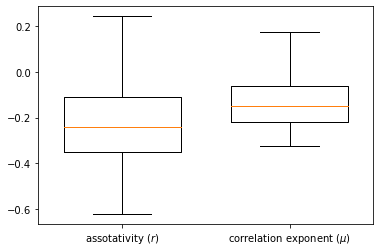

In [22]:
## compare r and mu vs random models for Dakota: G = SD+ND
## here we use the configuration model from Viger and Latapy
## we alse report the proportion of nodes above the structural cutoff
## given the degree distribution.
r = []
mu = []
for i in range(1000):    
    cm = ig.Graph.Degree_Sequence(G_D.degree(),method="vl")
    r.append(cm.assortativity_degree())
    mu.append(corr_exp(cm))
## structural cutoff
sc = np.sqrt(2*G_D.ecount())
p = len([x for x in G_D.degree() if x > sc])/G_D.vcount()
print('r =',G_D.assortativity_degree(),'mu =',corr_exp(G_D),'P(edges above structural cutoff) =', p)
plt.boxplot([r,mu],labels=[r'assotativity ($r$)',r'correlation exponent ($\mu$)'],widths=.7,sym='');
#plt.savefig('config_D.eps');

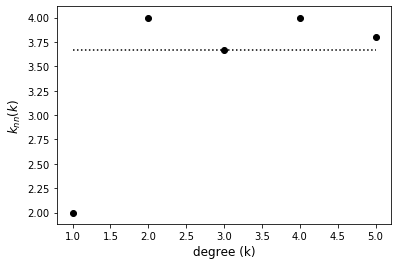

In [26]:
## degree correlation function for the Dakota graph
knn = deg_corr(G_D)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(G_D)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_D.eps')

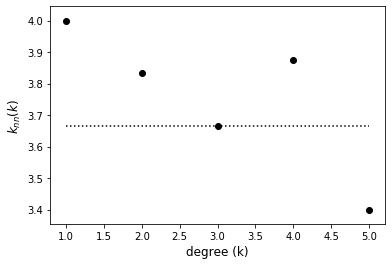

In [29]:
## degree correlation function for (last) random graph
## quite different!
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO_cm.eps')

r = -0.546798029556651


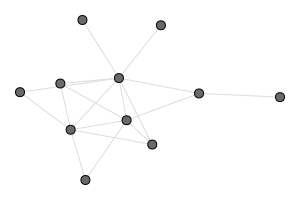

In [30]:
## negative case: the MO graph (Missouri) 
hva = [v for v in g.vs() if v['state'] == 'MO' ]
G_MO = g.subgraph(hva)
G_MO = G_MO.subgraph([v for v in G_MO.vs() if v.degree()>0])
G_MO = G_MO.simplify(multiple=False)
print('r =',G_MO.assortativity_degree())
ig.plot(G_MO, "MO.eps", bbox=(0,0,300,200))

r = -0.546798029556651 mu = -0.34485253746081135 P(edges above structural cutoff) = 0.09090909090909091


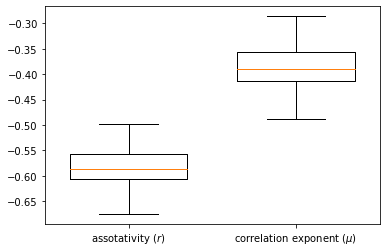

In [31]:
## r and mu vs random configuration model for MO graph
r = []
mu = []
for i in range(1000):    
    cm = ig.Graph.Degree_Sequence(G_MO.degree(),method="vl")
    r.append(cm.assortativity_degree())
    mu.append(corr_exp(cm))
## structural cutoff
sc = np.sqrt(2*G_MO.ecount())
p = len([x for x in G_MO.degree() if x > sc])/G_MO.vcount()
print('r =',G_MO.assortativity_degree(),'mu =',corr_exp(G_MO),'P(edges above structural cutoff) =', p)
plt.boxplot([r,mu],labels=[r'assotativity ($r$)',r'correlation exponent ($\mu$)'],widths=.7,sym='');
#plt.savefig('config_MO.eps');

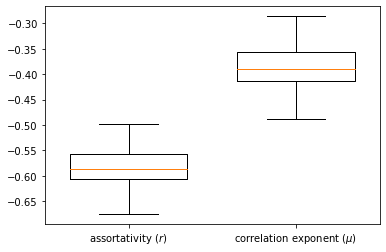

In [32]:
## we can also use rejection sampling (this can be slow)
G_MO.vs['degree'] = G_MO.degree()
V = []
for v in G_MO.vs():
    V.extend(np.repeat(v.index,v['degree']))
r = []
mu = []
for rep in range(1000):
    notdone = True
    while notdone:
        np.random.shuffle(V)
        notdone = False
        rg = ig.Graph()
        rg.add_vertices(np.max(V)+1)
        for i in np.arange(0,len(V),2):
            a, b = V[i], V[i+1]
            if a == b or rg.get_eid(a,b,error=False) != -1:
                notdone = True
                break
            else:
                rg.add_edge(a,b)
    r.append(rg.assortativity_degree())
    mu.append(corr_exp(rg))

plt.boxplot([r,mu],labels=[r'assortativity ($r$)',r'correlation exponent ($\mu$)'],widths=.7,sym='');
# plt.savefig('reject_MO.png');

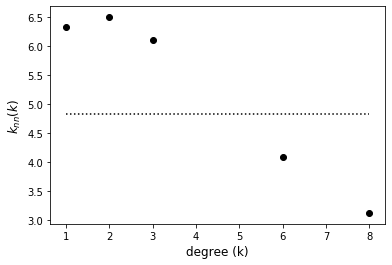

In [33]:
## degree correlation function for MO graph
knn = deg_corr(G_MO)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(G_MO)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO.eps')

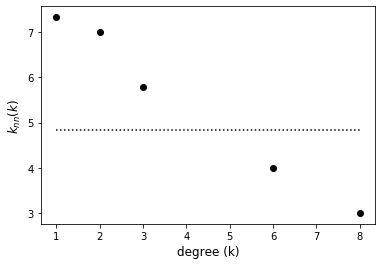

In [34]:
## degree correlation function for (last) random graph
## quite similar!
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO_cm.eps')

-1.0


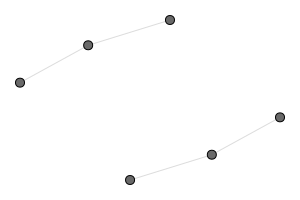

In [35]:
## state with r = -1 (NE)
hva = [v for v in g.vs() if v['state'] == 'NE' ]
G = g.subgraph(hva)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)
print(G.assortativity_degree())
ig.plot(G, "NE.eps", bbox=(0,0,300,200))

1.0


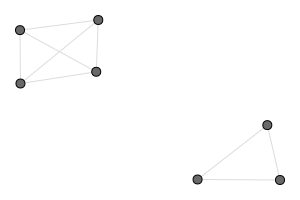

In [36]:
## state with r = +1 (AR) 
hva = [v for v in g.vs() if v['state'] == 'AR' ]
G = g.subgraph(hva)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)
print(G.assortativity_degree())
ig.plot(G, "AR.eps", bbox=(0,0,300,200))

## Back to Overall US Airport graph 

- friendship paradox illustration
- looking for rich club phenomenon


r = -0.05542639533339339


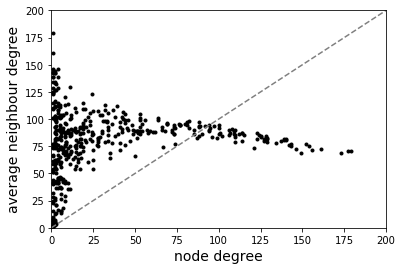

In [37]:
## plot degree vs avg neighbour degree
## friendship 'paradox' US Airport graph (overall)
deg = [v.degree() for v in g.vs()]
nad = []
for v in g.vs():
    nv = g.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,200))
plt.ylim((0,200))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,200],[0,200],'--', c='gray')
print('r =',g.assortativity_degree());
#plt.savefig('friendship.eps')

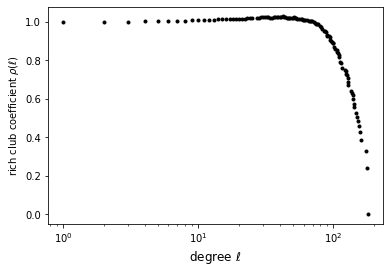

In [38]:
## looking for rich club -- not here!
d = list(set(g.degree()))
rc = []
for i in d:
    rc.append(richClub(g, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

## A quick look: Europe electric grid network

We notice:

- degree distribution quite uniform
- positive assortativity, also seen with degree correlation function
- friendship paradox not obvious

In [40]:
## Europe Electric Grid
grid = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
grid = grid.simplify()

r = 0.014442965703580286


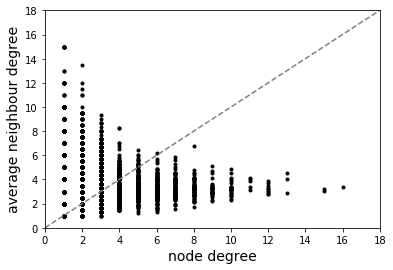

In [41]:
## plot degree vs avg neighbour degree
deg = [v.degree() for v in grid.vs()]
nad = []
for v in grid.vs():
    nv = grid.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,18))
plt.ylim((0,18))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,18],[0,18],'--', c='gray')
print('r =',grid.assortativity_degree());
#plt.savefig('friendship_grid.eps')

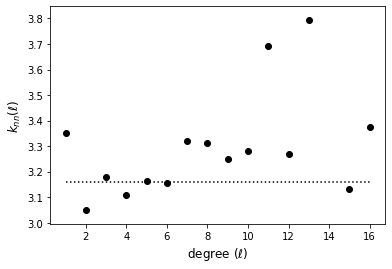

In [42]:
## Degree correlation function
knn = deg_corr(grid)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(grid)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_grid.eps')

## Quick look: GitHub Developers Graph

- negative assortativity
- strong friendship paradox phenomenon

In [43]:
## GitHub Developpers (undirected)
D = pd.read_csv(datadir+'GitHubDeveloppers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
git = ig.Graph.TupleList(tuples, directed = False)

r = -0.07521713413904482


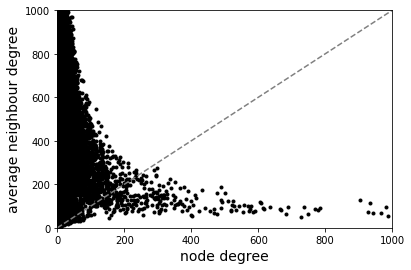

In [44]:
## plot degree vs avg neighbour degree
## zoom in on nodes with degree < LIM
LIM = 1000
deg = [v.degree() for v in git.vs()]
nad = []
for v in git.vs():
    nv = git.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,LIM))
plt.ylim((0,LIM))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,LIM],[0,LIM],'--', c='gray')
print('r =',git.assortativity_degree());
#plt.savefig('friendship_github.eps')

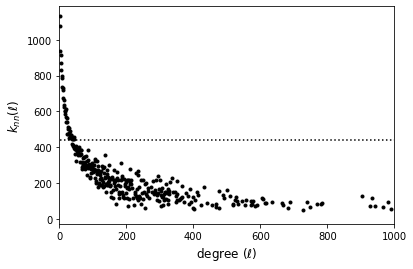

In [45]:
## degree correlation function
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_random(git)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')

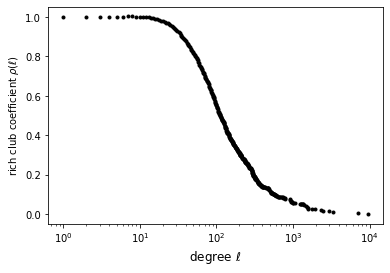

In [46]:
## still no rich club group here
d = list(set(git.degree()))
rc = []
for i in d:
    rc.append(richClub(git, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club_github.eps');

## Showing a rich club: the actors graph

In [48]:
## Actors
D = pd.read_csv(datadir+'Actors/movie_actors.net', sep=' ')
tuples = [tuple(x) for x in D.values]
g = ig.Graph.TupleList(tuples, directed = False)

## This can be slow -- you may want to take a sample first
d = np.random.choice(list(set(g.degree())),size=200,replace=False) ## sample
#d = list(set(g.degree())) ## full

rc = []
for i in d:
    rc.append(richClub(g, l=i))

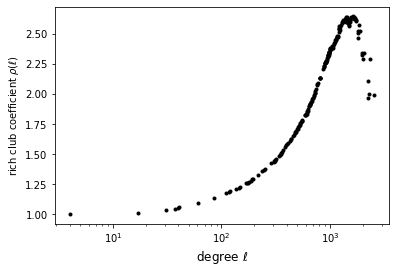

In [49]:
## rich club coefficients
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club_actors.eps')

## Figures 4.1 and 4.2: Xulvi-Brunet and Sokolov algorithm

In [50]:
## Xulvi-Brunet and Sokolov algorithm
def XBS(n, d, q, assortative):
    p = d/n
    g = ig.Graph.Erdos_Renyi(n,p)
    g.es['touched'] = False
    ec = g.ecount()
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            if np.random.random()<q:
                idx = np.argsort(g.degree(nodes))
                if assortative:
                    e1 = (nodes[idx[0]],nodes[idx[1]])
                    e2 = (nodes[idx[2]],nodes[idx[3]])
                else:
                    e1 = (nodes[idx[0]],nodes[idx[3]])
                    e2 = (nodes[idx[1]],nodes[idx[2]])
            else:
                np.random.shuffle(nodes)
                e1 = (nodes[0],nodes[1])
                e2 = (nodes[2],nodes[3])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        if sum(g.es['touched']) == g.ecount():
            break
    return g

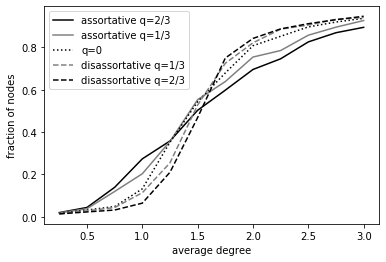

In [54]:
## Fig 4.2 with N nodes and averaging Rep results
N = 2**8 ## 2**16 and 64 in book
Rep = 10
Q = [2/3,1/3,0,1/3,2/3]
A = [True,True,True,False,False]
x = np.arange(0.25,3.01,.25)
Y = []

for i in range(len(Q)):
    y = []
    for d in x:
        sz = 0
        for rep in range(Rep):
            g = XBS(n = N, d = d, q = Q[i] , assortative = A[i])
            sz += g.clusters().giant().vcount()/g.vcount()
        y.append(sz / Rep)
    Y.append(y)
    
clr = ['black','gray','black','gray','black']
typ = ['-','-',':','--','--']
lbl = ['assortative q=2/3','assortative q=1/3','q=0','disassortative q=1/3','disassortative q=2/3']
for i in range(len(Y)):
    plt.plot(x,Y[i],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel('average degree')
plt.ylabel('fraction of nodes')
plt.legend();


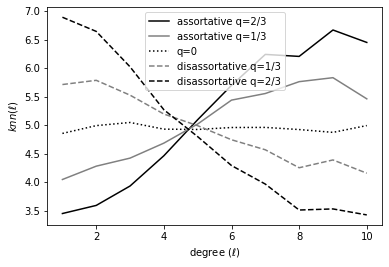

In [55]:
## Fig 4.1 
Y = []
for i in range(len(Q)):
    D = pd.DataFrame()
    for rep in range(Rep):
        g = XBS(n = N, d = 4, q = Q[i] , assortative = A[i])
        deg = g.degree()
        g.delete_vertices([i for i in range(len(deg)) if deg[i]==0])
        knn = deg_corr(g)
        D = pd.concat([D,pd.DataFrame(np.transpose(np.array([list(knn.keys()),list(knn.values())])))])
    X = D.groupby(by=0).mean()
    plt.plot(list(X.index)[:10],list(X[1])[:10],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel(r'degree ($\ell$)')
plt.ylabel(r'$knn(\ell)$')
plt.legend();